# Домашняя работа № 4

1. *Создать модель (торговую стратегию) на основе классического машинного обучения для прогнозирования оптимального торгового действия.*
2. *Провести тестирование разработанной стратегии на валидационном датасете.*
3. *Зафиксировать метрики модели для дальнейшего сравнения экспериментов.*
4. *Сформировать дашборд, показывающий эффективность различных торговых стратегий.*

In [1]:
#Подключаем библиотеки

import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
from scipy import stats
import plotly.express as px
import talib
import matplotlib.pyplot as plt
import pywt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from datetime import date, datetime, timedelta
from plotly.subplots import make_subplots
from backtesting import Backtest, Strategy

C:\Users\zarocool\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# Загружаем данные
data = pd.read_csv('Investing_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [3]:
data

,Date,Adj Close,Close,High,Low,Open,Volume,tic,type
0,2019-02-01,39.718460,41.630001,42.244999,41.482498,41.740002,130672400,AAPL,stock
1,2019-02-04,40.846664,42.812500,42.915001,41.820000,41.852501,125982000,AAPL,stock
2,2019-02-05,41.545528,43.544998,43.770000,43.087502,43.215000,144406400,AAPL,stock
3,2019-02-06,41.559845,43.560001,43.892502,43.212502,43.662498,112958400,AAPL,stock
4,2019-02-07,40.772709,42.735001,43.485001,42.584999,43.099998,126966800,AAPL,stock
...,...,...,...,...,...,...,...,...,...
7705,2025-03-14,121.669998,121.669998,121.879997,118.150002,118.610001,277593500,NVDA,stock
7706,2025-03-17,119.529999,119.529999,122.889999,118.029999,122.739998,255501500,NVDA,stock
7707,2025-03-18,115.430000,115.430000,119.019997,114.540001,118.000000,299686900,NVDA,stock
7708,2025-03-19,117.519997,117.519997,120.449997,115.680000,117.269997,273426200,NVDA,stock


#### Добавляем признаки

In [4]:
df = pd.DataFrame()
for i in data["tic"].unique():
    data_temp = data.loc[data['tic'] == i]
    data_temp.loc[:,['sma_5']] = talib.SMA(data_temp["Close"], timeperiod=5)
    data_temp.loc[:,['sma_10']] = talib.SMA(data_temp["Close"], timeperiod=10)
    data_temp.loc[:,['sma_15']] = talib.SMA(data_temp["Close"], timeperiod=15)
    data_temp.loc[:,['sma_20']] = talib.SMA(data_temp["Close"], timeperiod=20)
    data_temp.loc[:,['sma_50']] = talib.SMA(data_temp["Close"], timeperiod=50)
    data_temp.loc[:,['sma_200']] = talib.SMA(data_temp["Close"], timeperiod=200)
    data_temp.loc[:,['sma_ratio_5_15']] = data_temp['sma_15'] / data_temp['sma_5']
    data_temp.loc[:,['sma_ratio_10_50']] = data_temp['sma_50'] / data_temp['sma_15']
    data_temp.loc[:,['sma_5_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=5)
    data_temp.loc[:,['sma_10_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=10)
    data_temp.loc[:,['sma_15_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=15)
    data_temp.loc[:,['sma_50_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=50)
    data_temp.loc[:,["sma_Volume_ratio_5_15"]] = data_temp['sma_5_Volume'] / data_temp['sma_15_Volume']
    data_temp.loc[:,["sma_Volume_ratio_10_50"]] = data_temp['sma_10_Volume'] / data_temp['sma_50_Volume']
    data_temp.loc[:,["ema_5"]] = talib.EMA(data_temp["Close"], timeperiod=5)
    data_temp.loc[:,["ema_10"]] = talib.EMA(data_temp["Close"], timeperiod=10)
    data_temp.loc[:,["ema_20"]] = talib.EMA(data_temp["Close"], timeperiod=20)
    data_temp.loc[:,["ema_50"]] = talib.EMA(data_temp["Close"], timeperiod=50)
    data_temp.loc[:,["ema_200"]] = talib.EMA(data_temp["Close"], timeperiod=200)
    
    # Calculate the Bollinger Bands
    data_temp.loc[:,["upper_band"]], data_temp.loc[:,["middle_band"]], data_temp.loc[:,["lower_band"]] = talib.BBANDS(data_temp["Close"], timeperiod=20)
    
    # Calculate the relative strength index (RSI)
    data_temp.loc[:,["RSI"]] = talib.RSI(data_temp["Close"], timeperiod=14)
    
    # Calculate the MACD
    data_temp.loc[:,["macd"]], data_temp.loc[:,["macd_signal"]], data_temp.loc[:,["macd_hist"]] = talib.MACD(data_temp["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    
    data_temp.loc[:,['ADX_5']] = talib.ADX(data_temp['High'], data_temp['Low'], data_temp['Close'], timeperiod=5)
    data_temp.loc[:,['ADX_15']] = talib.ADX(data_temp['High'], data_temp['Low'], data_temp['Close'], timeperiod=15)
    
    data_temp.loc[:,['RSI_5']] = talib.RSI(data_temp['Close'], timeperiod=5)
    data_temp.loc[:,['RSI_15']] = talib.RSI(data_temp['Close'], timeperiod=15)
    data_temp.loc[:,['RSI_ratio']] = data_temp['RSI_5']/data_temp['RSI_15']
    
    data_temp.loc[:,['ROC']] = talib.ROC(data_temp['Close'], timeperiod=15)

    data_temp.loc[:,['HAMMER']] = talib.CDLHAMMER(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['SHOOTING_STAR']] = talib.CDLSHOOTINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['ENGULFING']] = talib.CDLENGULFING(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['MORNING_STAR']] = talib.CDLMORNINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['EVENING_STAR']] = talib.CDLEVENINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['MARUBOZU']] = talib.CDLMARUBOZU(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['DOJI']] = talib.CDLDOJI(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['lag_1day']] = data_temp['Close'].shift(1)
    data_temp.loc[:,['day_of_week']] = data_temp['Date'].dt.dayofweek

    data_temp.loc[:,['diff']] = -data_temp['Close'].diff(periods=-1)/data_temp['Close']
    
    #Определим, что значение таргета как -1, 0, 1 (продажа/держать/покупка) с учетом комиссии в 1%
    data_temp.loc[:,['target']] = 0
    data_temp.loc[data_temp['diff'] > 0.01, 'target'] = 1
    data_temp.loc[data_temp['diff'] < -0.01, 'target'] = -1
   
    
    data_temp.dropna(inplace=True)
    df = pd.concat([df, data_temp], ignore_index=True)

C:\Users\zarocool\AppData\Local\Temp\ipykernel_18436\4110441686.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp.dropna(inplace=True)
C:\Users\zarocool\AppData\Local\Temp\ipykernel_18436\4110441686.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp.dropna(inplace=True)
C:\Users\zarocool\AppData\Local\Temp\ipykernel_18436\4110441686.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp.dropna(inplace=T

#### Добавляем компоненты вейвлет разложения как признаки

In [5]:
# Функция по разложению на компоненты, добавим их дальше как отдельные признаки
def get_wavelet_features(history, wavelet='db4', level=5):
    coeffs = pywt.wavedec(history, wavelet, level=level)
    features = {}
    for i, name in enumerate(['cA5', 'cD5', 'cD4', 'cD3', 'cD2', 'cD1']):
        if i < len(coeffs):
            # Берём среднее последних 5 коэффициентов для стабильности
            features[name] = np.mean(coeffs[i][-5:])
    return features

# Функция вейвлет-прогнозирования на 1 день вперёд, также добавим предсказание как признак
def wavelet_forecast(history, wavelet='db4', level=5):
    coeffs = pywt.wavedec(history, wavelet, level=level)
    threshold = 0.2
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    restored = pywt.waverec(coeffs, wavelet)
    
    # Возвращаем последнее значение как прогноз
    return restored[-1] if len(restored) > 0 else np.nan

# Используем окно в 128 значения
window_size = 128
wavelet_df = pd.DataFrame()
for tic in df["tic"].unique():
    wavelet_features_list = []
    
    for i in range(window_size, len(data[data['tic']== tic])):
        window = data[data['tic']== tic]['Close'].values[i - window_size:i]
        features = get_wavelet_features(window)
        features['wavelet_forecast'] = wavelet_forecast(window)
        features['Date'] = data[data['tic']== tic]['Date'].iloc[i]
        features['tic'] = tic
        wavelet_features_list.append(features)
    
    wavelet_df = pd.concat([wavelet_df, pd.DataFrame(wavelet_features_list).fillna(0)], ignore_index=True)
# Объединяем основной DataFrame с вейвлетами
df = pd.merge(df, wavelet_df, on=['Date', 'tic'], how='inner')


C:\tools\Anaconda3\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [6]:
#Определим признаки, с которыми будет работать модель
features = ['sma_5', 'sma_10', 'sma_15', 'sma_50', 'sma_200', 'sma_ratio_5_15', 'sma_ratio_10_50', 
            'sma_5_Volume', 'sma_10_Volume', 'sma_15_Volume', 'sma_50_Volume', 'sma_Volume_ratio_5_15', 'sma_Volume_ratio_10_50', 'upper_band',
            'middle_band', 'lower_band', 'RSI', 'macd', 'macd_signal', 'macd_hist','day_of_week','lag_1day','cA5', 'cD5', 'cD4', 'cD3', 'cD2', 'cD1','wavelet_forecast',
            'ADX_5', 'ADX_15', 'RSI_5', 'RSI_15', 'RSI_ratio', 'ROC','HAMMER','SHOOTING_STAR','ENGULFING','MORNING_STAR','EVENING_STAR','MARUBOZU','DOJI']

In [7]:
df.dropna(inplace=True)
df = df.sort_values(by = ['Date','tic'],ascending = True, ignore_index = True)

#### Разделим данные на обучающую выборку, валидационную и тестовую

In [8]:
def split(df):
    train_value = int(len(df) * 0.7)
    val_value = int(len(df) * 0.15)
    test_value = int(len(df) * 0.15)
    
    train_df = df.iloc[:train_value]
    val_df = df.iloc[train_value:(train_value+val_value)]
    test_df = df.iloc[(val_value+train_value):]
    X_train, X_val, X_test = train_df[features], val_df[features], test_df[features]
    y_train, y_val, y_test = train_df["target"], val_df["target"], test_df["target"]
    return X_train,y_train,X_val,y_val,X_test,y_test, val_value+train_value
X_train,y_train,X_val,y_val,X_test,y_test, len_tr_val = split(df)

#### Нормализируем данные

In [9]:
# Инициализируем скалер
scaler = MinMaxScaler()

# Обучаем скалер только на тренировочных данных
X_train = scaler.fit_transform(X_train)

# Применяем тот же скалер к валидационным и тестовым данным, чтобы не заглядывать в будущее
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Используем Optuna для подбора гипперпараметров

[I 2025-05-06 20:03:02,915] A new study created in memory with name: no-name-537f2e2e-1a89-4c3a-b49b-ea398dd79882
[I 2025-05-06 20:03:15,580] Trial 0 finished with value: 0.22369000440334655 and parameters: {'n_estimators': 171, 'learning_rate': 0.24245827971770886, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.8188976334794177, 'max_features': 'sqrt', 'ccp_alpha': 0.02400752274677297}. Best is trial 0 with value: 0.22369000440334655.
[I 2025-05-06 20:05:10,571] Trial 1 finished with value: 0.22369000440334655 and parameters: {'n_estimators': 215, 'learning_rate': 0.23207668897982067, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.9718990882354496, 'max_features': None, 'ccp_alpha': 0.07656284678942277}. Best is trial 0 with value: 0.22369000440334655.
[I 2025-05-06 20:05:18,066] Trial 2 finished with value: 0.22369000440334655 and parameters: {'n_estimators': 178, 'learning_rate': 0.09160859622117379, 'max_depth': 4, 'min_

GradientBoosting - Best F1 macro on val: 0.3622
GradientBoosting - Test F1 macro: 0.3534

Confusion Matrix (GradientBoosting):
[[ 31 156  63]
 [ 74 331  74]
 [ 29 171  78]]


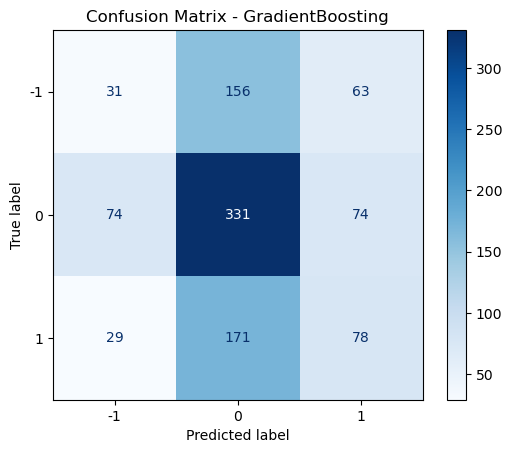

[I 2025-05-06 20:11:31,350] A new study created in memory with name: no-name-4001510d-da50-4dc1-b87a-71142ba3f2f7



Classification Report (GradientBoosting):
              precision    recall  f1-score   support

          -1       0.23      0.12      0.16       250
           0       0.50      0.69      0.58       479
           1       0.36      0.28      0.32       278

    accuracy                           0.44      1007
   macro avg       0.37      0.37      0.35      1007
weighted avg       0.40      0.44      0.40      1007



[I 2025-05-06 20:11:41,139] Trial 0 finished with value: 0.3381695479724125 and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 64, 'learning_rate': 0.2375747234290467, 'depth': 10, 'l2_leaf_reg': 2.1136886070342463e-08, 'random_strength': 4.142622775886275, 'grow_policy': 'Depthwise', 'subsample': 0.720683117802857}. Best is trial 0 with value: 0.3381695479724125.
[I 2025-05-06 20:11:50,205] Trial 1 finished with value: 0.3311549165651025 and parameters: {'bootstrap_type': 'Bayesian', 'iterations': 254, 'learning_rate': 0.28318179677252414, 'depth': 7, 'l2_leaf_reg': 2.2022124560587148e-06, 'random_strength': 4.152999831152941, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.3381695479724125.
[I 2025-05-06 20:11:53,720] Trial 2 finished with value: 0.360774835823775 and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 96, 'learning_rate': 0.0802217573251967, 'depth': 7, 'l2_leaf_reg': 4.190558526110926e-06, 'random_strength': 5.287364394006315, 'grow_

CatBoost - Best F1 macro on val: 0.3792
0:	learn: 1.0940409	total: 5.25ms	remaining: 1.48s
1:	learn: 1.0898930	total: 9.93ms	remaining: 1.39s
2:	learn: 1.0858451	total: 16.4ms	remaining: 1.53s
3:	learn: 1.0822092	total: 21.7ms	remaining: 1.51s
4:	learn: 1.0788105	total: 26.9ms	remaining: 1.49s
5:	learn: 1.0758105	total: 33.3ms	remaining: 1.53s
6:	learn: 1.0730514	total: 38.3ms	remaining: 1.5s
7:	learn: 1.0704759	total: 43.3ms	remaining: 1.48s
8:	learn: 1.0680995	total: 49.4ms	remaining: 1.5s
9:	learn: 1.0657867	total: 54.6ms	remaining: 1.48s
10:	learn: 1.0635086	total: 59.8ms	remaining: 1.47s
11:	learn: 1.0615473	total: 66ms	remaining: 1.49s
12:	learn: 1.0596545	total: 71.5ms	remaining: 1.48s
13:	learn: 1.0578958	total: 76.6ms	remaining: 1.47s
14:	learn: 1.0563819	total: 82.8ms	remaining: 1.47s
15:	learn: 1.0546857	total: 88.1ms	remaining: 1.46s
16:	learn: 1.0532805	total: 93.4ms	remaining: 1.46s
17:	learn: 1.0517728	total: 99.6ms	remaining: 1.46s
18:	learn: 1.0503535	total: 105ms	rema

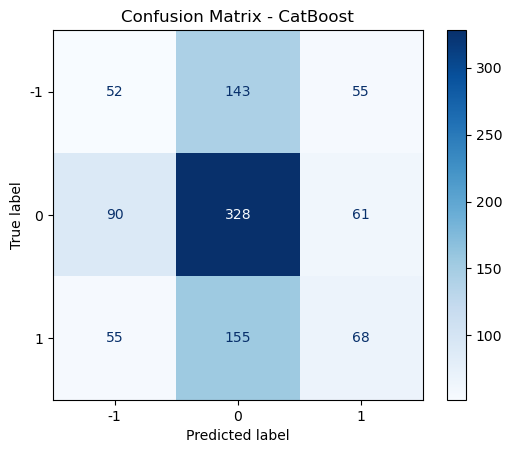


Classification Report (CatBoost):
              precision    recall  f1-score   support

          -1       0.26      0.21      0.23       250
           0       0.52      0.68      0.59       479
           1       0.37      0.24      0.29       278

    accuracy                           0.44      1007
   macro avg       0.39      0.38      0.37      1007
weighted avg       0.42      0.44      0.42      1007


📊 Final Results:
GradientBoosting: Val F1 macro = 0.3622, Test F1 macro = 0.3534
CatBoost: Val F1 macro = 0.3792, Test F1 macro = 0.3736


In [10]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt

# Функция для создания objective в зависимости от модели
def create_objective(X_train, y_train, X_val, y_val, model_class):
    def objective(trial):
        if model_class == GradientBoostingClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10), #ограничение глубины деревьев
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),# используются случайные подвыборки данных для обучения каждого дерева
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.1), #регуляризация, штраф за сложность деревьев
                'random_state': 42
            }

        elif model_class == CatBoostClassifier:
            bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
            params = {
                'iterations': trial.suggest_int('iterations', 50, 300),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 3, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),#коэффициент L2-регуляризации на листьях деревьев
                'bootstrap_type': bootstrap_type,
                'random_strength': trial.suggest_float('random_strength', 0.01, 10.0),
                'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
                'random_state': 42,
                'verbose': False
            }
            # Добавляем subsample только если не Bayesian, иначе будет ошибка
            if bootstrap_type == 'Bernoulli':
                params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0)

        else:
            raise ValueError("Unsupported model class")

        model = model_class(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')

        return score
    return objective


# Модели используем GradientBoosting и CatBoost
MODELS = {
    'GradientBoosting': GradientBoostingClassifier,
    'CatBoost': CatBoostClassifier
}

results = {}

for model_name, model_class in MODELS.items():

    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    objective_func = create_objective(X_train, y_train, X_val, y_val, model_class)
    study.optimize(objective_func, n_trials=30)

    best_params = study.best_params
    best_score = study.best_value
    print(f"{model_name} - Best F1 macro on val: {best_score:.4f}")

    # Обучение лучшей модели на трейне
    best_model = model_class(**best_params, random_state=42)
    best_model.fit(X_train, y_train)

    # Предсказание на тесте
    y_test_pred = best_model.predict(X_test)

    # Оценка качества
    test_f1 = f1_score(y_test, y_pred=y_test_pred, average='macro')
    print(f"{model_name} - Test F1 macro: {test_f1:.4f}")

    # Сохраняем результаты
    results[model_name] = {
        'model': best_model,
        'val_score': best_score,
        'test_score': test_f1,
        'y_pred': y_test_pred
    }

    # Confusion Matrix
    print(f"\nConfusion Matrix ({model_name}):")
    cm = confusion_matrix(y_test, y_test_pred, labels=[-1, 0, 1])
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1', '0', '1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Classification Report
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_test, y_test_pred, target_names=['-1', '0', '1']))


# --- Итог по всем моделям ---
print("\n📊 Final Results:")
for name, res in results.items():
    print(f"{name}: Val F1 macro = {res['val_score']:.4f}, Test F1 macro = {res['test_score']:.4f}")

In [11]:
test_df_gb = df.iloc[len_tr_val:].copy()
test_df_cb = df.iloc[len_tr_val:].copy()
test_df_gb.loc[:,["signal"]] = results['GradientBoosting']['model'].predict(X_test)
test_df_cb.loc[:,["signal"]] = results['CatBoost']['model'].predict(X_test)

In [18]:
#Функция по отрисовке акций и сигналов на покупку/продажу
def draw_signals(test_df):
    
    # Добавляем сигналы покупки и продажи
    buy_signals = test_df[test_df['signal'] == 1]
    sell_signals = test_df[test_df['signal'] == -1]
    hold_signals = test_df[test_df['signal'] == 0]
    
    for ticker in test_df.tic.unique():
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(x = test_df[test_df['tic'] == ticker]['Date'], y = test_df[test_df['tic'] == ticker]['Close'], name=ticker, visible=True))
        
        fig.add_trace(go.Scatter(x=buy_signals[buy_signals['tic']==ticker]['Date'], y = buy_signals[buy_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Покупка', marker=dict(symbol='triangle-up', size=10, color='green')))
        fig.add_trace(go.Scatter(x=sell_signals[sell_signals['tic']==ticker]['Date'], y=sell_signals[sell_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Продажа', marker=dict(symbol='triangle-down', size=10, color='red')))
        fig.add_trace(go.Scatter(x=hold_signals[hold_signals['tic']==ticker]['Date'], y=hold_signals[hold_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Держим', marker=dict(symbol='triangle-down', size=10, color='blue')))


        
        fig.show("png")   

### Графики движения акций с установленными сигналами на покупку/продажу по GradientBoosting

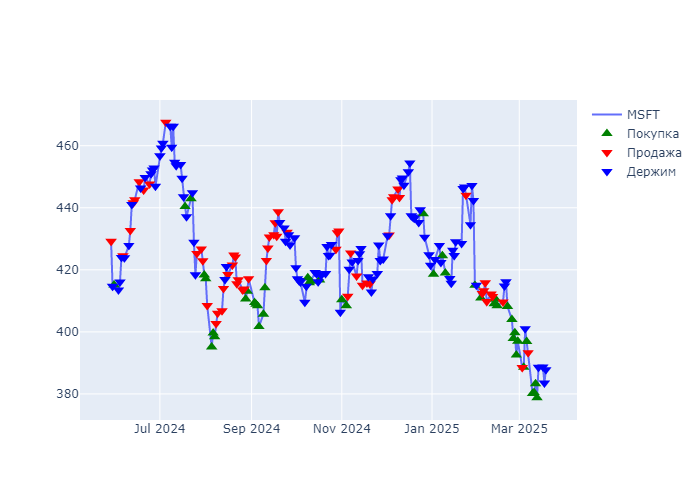

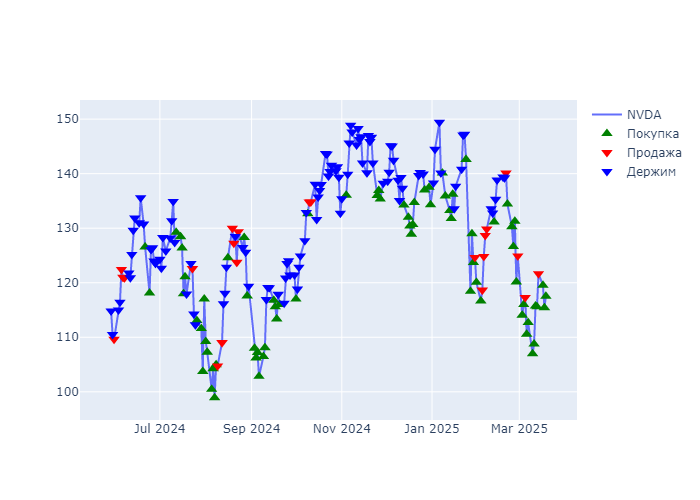

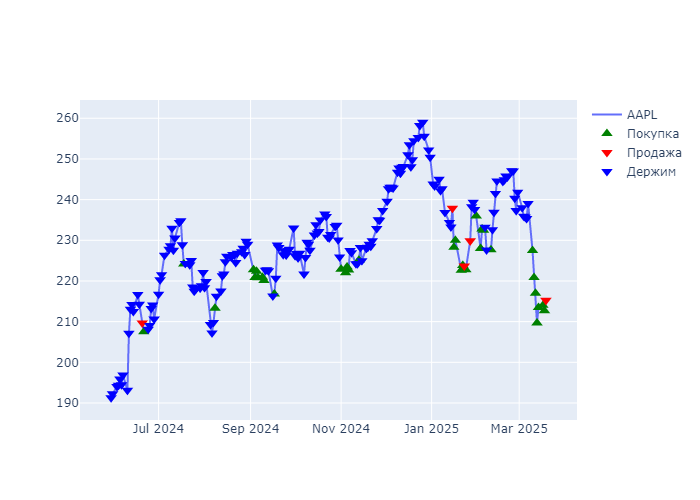

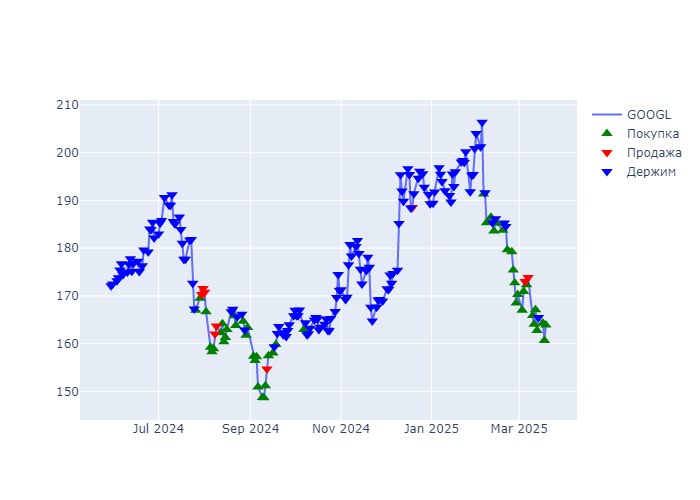

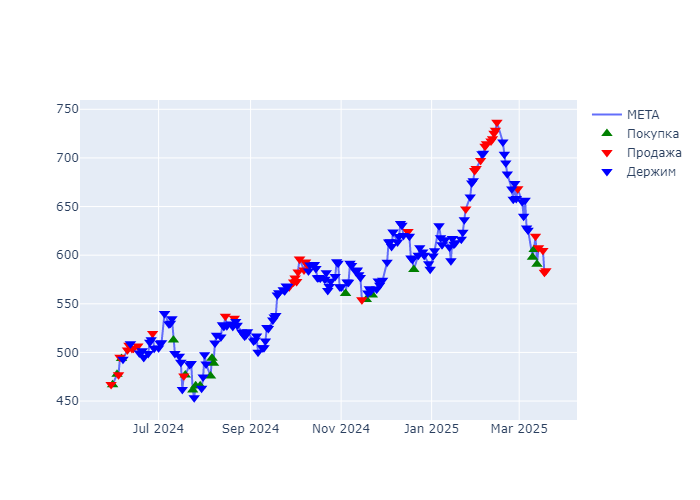

In [19]:
draw_signals(test_df_gb)

### Графики движения акций с установленными сигналами на покупку/продажу по CatBoost

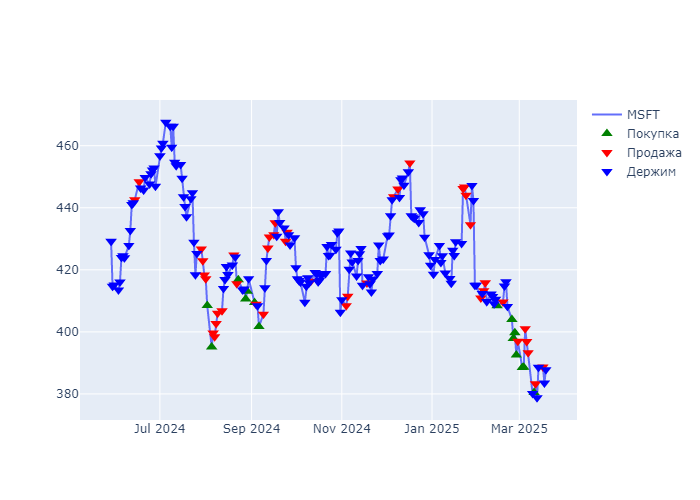

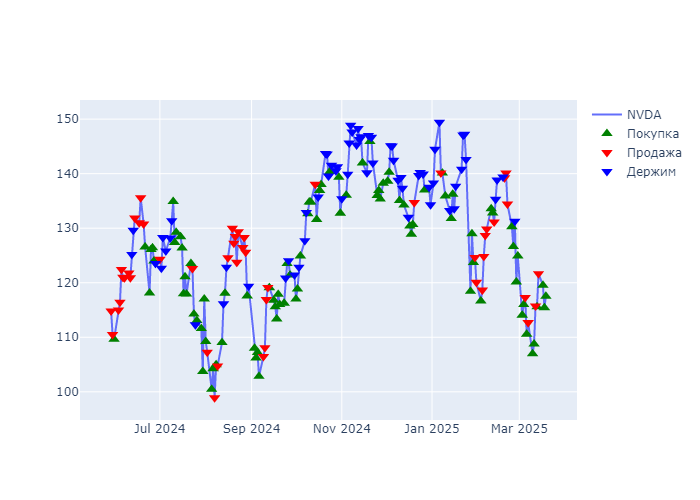

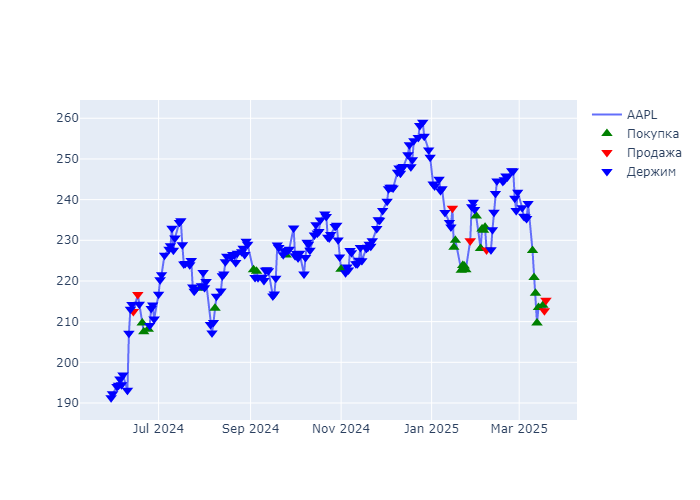

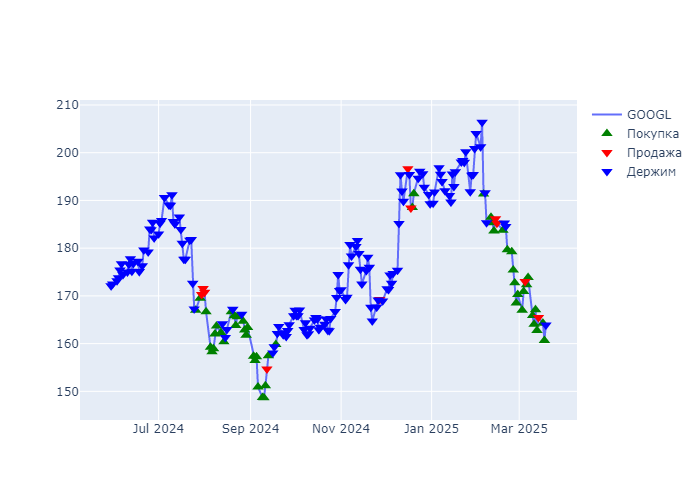

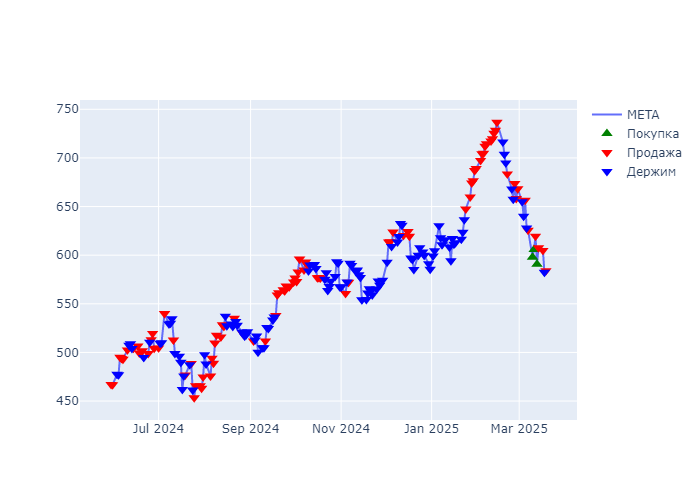

In [20]:
draw_signals(test_df_cb)

## Бэктест

Посмотрим на тестовой выборке, как модели поведут себя и будут ли они прибыльны. Используем библиотеку backtesting

In [15]:
# Добавим столбец где будет указан id трейда
def prepare_data(test_df):
    for ticker in df.tic.unique():
        test_df.loc[test_df['tic'] == ticker,['shift']] = test_df.loc[test_df['tic'] == ticker,'signal'].shift()
        test_df.loc[test_df['tic'] == ticker,['shift']].fillna(0, inplace=True)
        test_df.loc[test_df['tic'] == ticker,['action_x']] =test_df.loc[test_df['tic'] == ticker,'signal'].ne(test_df.loc[test_df['tic'] == ticker,'shift'])
        test_df.loc[test_df['tic'] == ticker,['action_id']] = test_df.loc[test_df['tic'] == ticker,'signal'].ne(test_df.loc[test_df['tic'] == ticker,'signal'].shift()).cumsum()
    return test_df
test_df_gb = prepare_data(test_df_gb)
test_df_cb = prepare_data(test_df_cb)

In [16]:
#Создаем стратегию для покупки / продажи согласно моделям
class ML_strategy(Strategy):
    def init(self):
        # переопределяем Индикатор по колонке Signal
        self.signal = self.I(lambda: self.data.Signal)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]
        if current_signal != self.previous_signal:
            if current_signal == 1:
                if self.position.is_short:
                    self.position.close()

                if not self.position.is_long:
                    self.buy()
            elif current_signal == -1:
                if self.position.is_long:
                    self.position.close()

                if not self.position.is_short:
                    self.sell()
            elif current_signal == 0:
                if self.position:
                    self.position.close()


        self.previous_signal = current_signal
        
# Делаем для каждой модели и акции свой объект класса Backtest
def bt_str(test_df):    
    db_all = pd.DataFrame()
    for ticker in df.tic.unique():  
        # Подготовка данных для бэктестинга
        bt_df = test_df[test_df['tic'] == ticker].copy()
        bt_df.columns = bt_df.columns.str.capitalize()
        bt_df.rename(columns={'Date': 'Datetime'}, inplace=True)
        bt_df["Datetime"] = pd.to_datetime(bt_df["Datetime"])
        bt_df.set_index('Datetime', inplace=True)
        
        # Создаем объект класса Backtest
        bt = Backtest(bt_df, ML_strategy, cash=1_000_000, commission=.002, exclusive_orders=True) # сделки идут последовательно
        
        stats = bt.run()
        
        db_all[ticker] =  stats[:27]
    return db_all
    
#Запускаем    
df_gb = bt_str(test_df_gb)
df_cb = bt_str(test_df_cb)

In [17]:
#Отрисуем результаты
result = pd.concat(
    [df_gb, df_cb],
    axis=1,
    keys=['GradB', 'CatB']
).swaplevel(axis=1).sort_index(axis=1)
result

AAPL                       \
                                       CatB                GradB   
Start                   2024-05-30 00:00:00  2024-05-30 00:00:00   
End                     2025-03-19 00:00:00  2025-03-19 00:00:00   
Duration                  293 days 00:00:00    293 days 00:00:00   
Exposure Time [%]                 20.895522            19.402985   
Equity Final [$]              928282.639915       1052327.923639   
Equity Peak [$]              1029943.055865       1130248.847185   
Commissions [$]                55636.690356         63527.099919   
Return [%]                        -7.171736             5.232792   
Buy & Hold Return [%]             12.520264            12.520264   
Return (Ann.) [%]                 -8.908115             6.603514   
Volatility (Ann.) [%]             10.477758            12.062511   
CAGR [%]                           -6.20001               4.4844   
Sharpe Ratio                      -0.850193             0.547441   
Sortino Ratio                     -1.011842              0.83101   
Calmar Ratio                      -0.809601             0.710118   
Max. Drawdown [%]                -11.003089            -9.299176   
Avg. Drawdown [%]                 -5.266146            -2.095618   
Max. Drawdown Duration    160 days 00:00:00     63 days 00:00:00   
Avg. Drawdown Duration     90 days 00:00:00     35 days 00:00:00   
# Trades                                 14                   15   
Win Rate [%]                           50.0            86.666667   
Best Trade [%]                     2.203502             3.419905   
Worst Trade [%]                   -4.284883            -3.162156   
Avg. Trade [%]                    -0.083525             1.018251   
Max. Trade Duration        11 days 00:00:00      8 days 00:00:00   
Avg. Trade Duration         4 days 00:00:00      3 days 00:00:00   
Profit Factor                      0.876401             4.379432   

                                      GOOGL                       \
                                       CatB                GradB   
Start                   2024-05-30 00:00:00  2024-05-30 00:00:00   
End                     2025-03-19 00:00:00  2025-03-19 00:00:00   
Duration                  293 days 00:00:00    293 days 00:00:00   
Exposure Time [%]                 35.323383            33.333333   
Equity Final [$]             1008522.159201        895056.821467   
Equity Peak [$]              1182734.629916        1167390.07474   
Commissions [$]                 95242.21044         90244.689789   
Return [%]                         0.852216           -10.494318   
Buy & Hold Return [%]             -4.776016            -4.776016   
Return (Ann.) [%]                  1.069603           -12.977091   
Volatility (Ann.) [%]             18.378994            15.678156   
CAGR [%]                           0.732528            -9.094903   
Sharpe Ratio                       0.058197            -0.827718   
Sortino Ratio                      0.090483            -1.035484   
Calmar Ratio                       0.065201            -0.522539   
Max. Drawdown [%]                -16.404791           -24.834688   
Avg. Drawdown [%]                 -5.950209           -12.718726   
Max. Drawdown Duration    218 days 00:00:00    223 days 00:00:00   
Avg. Drawdown Duration     75 days 00:00:00    113 days 00:00:00   
# Trades                                 22                   22   
Win Rate [%]                      59.090909            40.909091   
Best Trade [%]                    10.240132            10.240132   
Worst Trade [%]                   -6.297053            -6.297053   
Avg. Trade [%]                     0.440524            -0.101336   
Max. Trade Duration        16 days 00:00:00     14 days 00:00:00   
Avg. Trade Duration         4 days 00:00:00      4 days 00:00:00   
Profit Factor                        1.5588             0.951847   

                                       META                       \
                         

Вывод: качество моделей считаю не особо хорошими. На каких то акциях лучше отработал GradientBoosting, на каких то CatBoost, но в сумме результат неудовлетворительный. Следующим шагом думаю нужно будет использовать нейронные модели, например RNN.